<a href="https://colab.research.google.com/github/Lou1108/DeepLearning/blob/main/Assignment2/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install tensorflow

In [3]:
%pip install keras-tcn

In [4]:
!pip show keras-tcn

Name: keras-tcn
Version: 3.5.6
Summary: Keras TCN
Home-page: 
Author: Philippe Remy
Author-email: 
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, tensorflow
Required-by: 


In [5]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [6]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 18.6 MB/s eta 0:00:00


In [7]:
import os
import h5py
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization,DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.layers import Activation,AveragePooling2D, Conv2D, RepeatVector, Permute, Multiply, GlobalAveragePooling1D, GlobalAveragePooling2D, Reshape, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Input
from tcn import TCN
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.layers import LSTM
import keras_tuner as kt
from sklearn.model_selection import train_test_split

import numpy as np
import h5py
import glob # Used to find all file paths
import os

import optuna
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [8]:
BASE_PATH_CROSS = '/content/drive/MyDrive/Deep Learning/Final Project data/Cross'
BASE_PATH_INTRA = '/content/drive/MyDrive/Deep Learning/Final Project data/Intra'

CROSS_TRAIN_DIR = os.path.join(BASE_PATH_CROSS, 'train/')
TEST1_DIR = os.path.join(BASE_PATH_CROSS, 'test1/')
TEST2_DIR = os.path.join(BASE_PATH_CROSS, 'test2/')
TEST3_DIR = os.path.join(BASE_PATH_CROSS, 'test3/')
INTRA_TRAIN_DIR = os.path.join(BASE_PATH_INTRA, 'train/')
INTRA_TEST_DIR = os.path.join(BASE_PATH_INTRA, 'test/')

# Constants
N_CHANNELS = 248
TASKS = ['rest', 'task_motor', 'task_story_math', 'task_working_memory']
task_to_label = {task: i for i, task in enumerate(TASKS)}
DOWNSAMPLE_FACTOR = 10
WINDOW_SIZE = 250
STEP = 125

#loading and preprocessing funcs
def get_file_paths(directory):
    files = glob.glob(f"{directory}/*.h5")
    if not files:
        raise FileNotFoundError(f"No file found")
    return files

def load_data(file_paths):
    data = []
    labels = []
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        task = None
        if 'rest' in filename:
            task = 'rest'
        elif 'motor' in filename:
            task = 'task_motor'
        elif 'story' in filename or 'math' in filename:
            task = 'task_story_math'
        elif 'working' in filename or 'memory' in filename:
            task = 'task_working_memory'

        if task:
            labels.append(task_to_label[task])
            with h5py.File(file_path, 'r') as f:
                dataset_name = list(f.keys())[0]
                matrix = f[dataset_name][()]
                data.append(matrix)
    return np.array(data), np.array(labels)

def windowing(data, labels, window_size, step):
    X_win, y_win = [], []
    for i in range(data.shape[0]):
        n_windows = (data.shape[2] - window_size) // step + 1
        for j in range(n_windows):
            start=j*step
            end = start +window_size
            X_win.append(data[i, :, start:end])
            y_win.append(labels[i])
    return np.array(X_win), np.array(y_win)

def normalize_data(data):
    """function for appluing time wise z-score normalization to each window"""
    n_samples, n_channels, n_timesteps = data.shape
    # reshape for scaler: (samples * channels, timesteps)
    reshaped_data = data.reshape(n_samples * n_channels, n_timesteps)
    scaler = StandardScaler()

    scaled_data = scaler.fit_transform(reshaped_data)
    #reshap back to original shape
    return scaled_data.reshape(n_samples, n_channels, n_timesteps)

def augment_data(data, labels, noise_factor=0.05, scale_factor_range=(0.9, 1.1)):
    """applies noises and scaling augmentation"""
    augmented_data, augmented_labels = [], []
    for i in range(len(data)):
        original_sample = data[i]
        original_label = labels[i]
        # add org sample
        augmented_data.append(original_sample)
        augmented_labels.append(original_label)
        # add augmented sample
        noise = np.random.normal(loc=0.0, scale=noise_factor, size=original_sample.shape)
        scaler = np.random.uniform(low=scale_factor_range[0], high=scale_factor_range[1])
        augmented_sample = (original_sample + noise) * scaler
        augmented_data.append(augmented_sample)
        augmented_labels.append(original_label)
    return np.array(augmented_data), np.array(augmented_labels)


# preproccessing
def preprocess_pipeline(base_dir, is_training=True, output_format='2d'):

    files = get_file_paths(base_dir)
    X, y = load_data(files)
    X_ds = X[:, :, ::DOWNSAMPLE_FACTOR]

    X_win, y_win = windowing(X_ds, y, WINDOW_SIZE, STEP)

    X_norm = normalize_data(X_win)

    if is_training:
        X_aug, y_aug = augment_data(X_norm, y_win)
        final_X, final_y = X_aug, y_aug
    else:
        final_X, final_y = X_norm, y_win

    if output_format == '2d':
        # Reshape for EEGNet/2D CNNs by adding a final dimension
        final_X = final_X[..., np.newaxis]
    elif output_format == '1d':
        # Reshape for Simple/1D CNNs by swapping the last two axes
        final_X = np.transpose(final_X, (0, 2, 1))
    else:
        raise ValueError("Invalid output_format")

    return final_X, final_y

X_train_1D, y_train_1D_final = preprocess_pipeline(CROSS_TRAIN_DIR, is_training=True, output_format='1d')
X_test1_1D, y_test1_1D_final = preprocess_pipeline(TEST1_DIR, is_training=False, output_format='1d')
X_test2_1D, y_test2_1D_final = preprocess_pipeline(TEST2_DIR, is_training=False, output_format='1d')
X_test3_1D, y_test3_1D_final = preprocess_pipeline(TEST3_DIR, is_training=False, output_format='1d')

X_train_augmented = X_train_1D
y_train_augmented = y_train_1D_final
NUM_CLASSES = len(np.unique(y_train_1D_final))

INPUT_SHAPE = (X_train_1D.shape[1], X_train_1D.shape[2])

# CNN

In [9]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        Conv1D(filters=64, kernel_size=7, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling1D(pool_size=2),

        Conv1D(filters=128, kernel_size=5, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling1D(pool_size=2),

        Conv1D(filters=256, kernel_size=3, padding='same'),
        BatchNormalization(),
        Activation('relu'),
        GlobalAveragePooling1D(),  # instead of Flatten to reduce overfitting

        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

simple_cnn = build_cnn_model(INPUT_SHAPE, NUM_CLASSES)

simple_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

simple_cnn.summary()

# # --- Training ---
# simple_cnn.fit(
#     X_train_1D,
#     y_train_1D_final,
#     batch_size=32,
#     epochs=20,
#     validation_split=0.2,
#     verbose=2
# )



# # Evaluate on test sets
# loss1_simple_cnn, acc1_simple_cnn = simple_cnn.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
# print(f"simple_cnn Model Accuracy on Test Set 1: {acc1_simple_cnn * 100:.2f}%")
# loss2_simple_cnn, acc2_simple_cnn = simple_cnn.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
# print(f"simple_cnn Model Accuracy on Test Set 2: {acc2_simple_cnn * 100:.2f}%")
# loss3_simple_cnn, acc3_simple_cnn = simple_cnn.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
# print(f"simple_cnn Model Accuracy on Test Set 3: {acc3_simple_cnn * 100:.2f}%")

# print(f"Average accuracy: {((acc1_simple_cnn + acc2_simple_cnn +acc3_simple_cnn)/3) * 100:.2f}%")



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 250, 64)        │       111,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 250, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 125, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 125, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 125, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 62, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 62, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 62, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,020 (1.09 MB)

 Trainable params: 285,124 (1.09 MB)

 Non-trainable params: 896 (3.50 KB)

# LSTM

In [10]:
def build_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        # Convolutional layers to extract features
        Conv1D(filters=64, kernel_size=10, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=4),

        Conv1D(filters=128, kernel_size=10, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=4),

        # LSTM layer to model temporal sequences of the extracted features
        LSTM(128, return_sequences=False), # return_sequences=False  it's the last recurrent layer

        # Dense layers for classification
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

cnn_lstm_model = build_cnn_lstm_model(INPUT_SHAPE, NUM_CLASSES)

cnn_lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_lstm_model.summary()

# # --- Training ---
# cnn_lstm_model.fit(
#     X_train_1D,
#     y_train_1D_final,
#     batch_size=32,
#     epochs=20,
#     validation_split=0.2,
#     verbose=2
# )



# # Evaluate on test sets
# loss1_hybrid, acc1_hybrid = cnn_lstm_model.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
# print(f"Hybrid Model Accuracy on Test Set 1: {acc1_hybrid * 100:.2f}%")
# loss2_hybrid, acc2_hybrid = cnn_lstm_model.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
# print(f"Hybrid Model Accuracy on Test Set 2: {acc2_hybrid * 100:.2f}%")
# loss3_hybrid, acc3_hybrid = cnn_lstm_model.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
# print(f"Hybrid Model Accuracy on Test Set 3: {acc3_hybrid * 100:.2f}%")

# print(f"Average accuracy: {((acc1_hybrid + acc2_hybrid +acc3_hybrid)/3) * 100:.2f}%")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 250, 64)        │       158,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 250, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 62, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 62, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390,212 (1.49 MB)

 Trainable params: 389,828 (1.49 MB)

 Non-trainable params: 384 (1.50 KB)

# TCN

In [11]:
def build_tcn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        TCN(nb_filters=64, kernel_size=5, dilations=[1, 2, 4, 8, 16], return_sequences=False),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

build_tcn_model_model = build_tcn_model(INPUT_SHAPE, NUM_CLASSES)

build_tcn_model_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

build_tcn_model_model.summary()

# # --- Training ---
# build_tcn_model_model.fit(
#     X_train_1D,
#     y_train_1D_final,
#     batch_size=32,
#     epochs=20,
#     validation_split=0.2,
#     verbose=2
# )



# # Evaluate on test sets
# loss1_build_tcn_model, acc1_build_tcn_model = build_tcn_model_model.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
# print(f"temporal attention Model Accuracy on Test Set 1: {acc1_build_tcn_model * 100:.2f}%")
# loss2_build_tcn_model, acc2_build_tcn_model = build_tcn_model_model.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
# print(f"temporal attention Model Accuracy on Test Set 2: {acc2_build_tcn_model * 100:.2f}%")
# loss3_build_tcn_model, acc3_build_tcn_model = build_tcn_model_model.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)
# print(f"temporal attention Model Accuracy on Test Set 3: {acc3_build_tcn_model * 100:.2f}%")

# print(f"Average accuracy: {((acc1_build_tcn_model + acc2_build_tcn_model +acc3_build_tcn_model)/3) * 100:.2f}%")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn (TCN)                       │ (None, 64)             │       280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,516 (1.07 MB)

 Trainable params: 280,516 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

#**EEGNet**

In [12]:
def squeeze_excite_block(input_tensor, ratio=16):
    """Squeeze and Excite block for channelwise attention"""
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def EEGNet_with_Attention_Regularized(
    nb_classes, Chans=248, Samples=150, dropoutRate=0.5, l2_lambda=0.001
):
    """
    EEGNet model with Squeeze-and-Excite attention and L2 regularization
    """
    input1 = Input(shape=(Chans, Samples, 1))

    # Block 1: Temporal Conv
    block1 = Conv2D(F1, (1, kernLength), padding='same',
                    use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), use_bias=False,
                             depth_multiplier=D)(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)

    # Attention Block
    block1 = squeeze_excite_block(block1)

    # Block 2: Separable Convolution with L2 regularization
    block2 = SeparableConv2D(F2, (1, 16), use_bias=False, padding='valid',
                             depthwise_regularizer=l2(l2_lambda),
                             pointwise_regularizer=l2(l2_lambda))(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(dropoutRate)(block2)

    # Classification Head
    flatten = Flatten()(block2)
    dense = Dense(nb_classes, kernel_constraint=max_norm(0.25),
                  kernel_regularizer=l2(l2_lambda))(flatten)
    softmax = Activation('softmax')(dense)

    return Model(inputs=input1, outputs=softmax)

eegnet_model = EEGNet_with_Attention_Regularized(
    nb_classes=NUM_CLASSES,        # Set this based on your label count
    Chans=N_CHANNELS,              # Typically 248 for MEG
    Samples=WINDOW_SIZE,           # Use 150 or 250 based on your data
    dropoutRate=0.6,
    l2_lambda=0.001
)

def build_eegnet_model(input_shape, num_classes):
    # input_shape = (Chans, Samples, 1)
    Chans, Samples, _ = input_shape
    return EEGNet_with_Attention_Regularized(
        nb_classes=num_classes,
        Chans=Chans,
        Samples=Samples,
        dropoutRate=0.6,
        l2_lambda=0.001
    )

# Compile model
eegnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
eegnet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 248, 250,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 248, 250,  │        512 │ input_layer_3[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 248, 250,  │         32 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 1, 250,    │      3,968 │ batch_normalizat… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 250,    │         64 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 1, 250,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 1, 62, 16) │          0 │ activation_3[0][… │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1, 62, 16) │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ dropout_4[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 16)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1, 1, 1)   │         16 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1, 1, 16)  │         16 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 62, 16) │          0 │ dropout_4[0][0],  │
│                     │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 1, 47, 16) │        512 │ multiply[0][0]    │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 47, 16) │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 1, 47, 16) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 1, 5, 16)  │          0 │ activation_4[0][… │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1, 5, 16)  │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,508 (21.52 KB)

 Trainable params: 5,428 (21.20 KB)

 Non-trainable params: 80 (320.00 B)

# Optimization

In [22]:
import optuna
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# --- Assume preprocess_pipeline and build_eegnet_model are already defined above, and
# --- global variables WINDOW_SIZE, STEP, CROSS_TRAIN_DIR, TEST1_DIR, TEST2_DIR, TEST3_DIR exist.

def make_optimized_objective(build_fn, output_format, max_epochs=10, batch_size=32):
    best = {"model": None, "best_acc": 0.0}

    def objective(trial):
        global WINDOW_SIZE, STEP
        WINDOW_SIZE = trial.suggest_int("window_size", 100, 350, step=50)
        STEP        = trial.suggest_int("step_size", 25, 150, step=25)

        # Re-preprocess data
        Xtr, ytr = preprocess_pipeline(CROSS_TRAIN_DIR, True,  output_format)
        Xt1, y1  = preprocess_pipeline(TEST1_DIR,    False, output_format)
        Xt2, y2  = preprocess_pipeline(TEST2_DIR,    False, output_format)
        Xt3, y3  = preprocess_pipeline(TEST3_DIR,    False, output_format)

        # dimension check
        if output_format == '1d':
            # Xtr shape: (n_samples, time_steps, channels)
            if Xtr.shape[1] != WINDOW_SIZE:
                return 0.0
        else:  # '2d'
            # Xtr shape: (n_samples, channels, time_steps, 1)
            if Xtr.shape[2] != WINDOW_SIZE:
                return 0.0

        # build, compile, train
        model = build_fn(Xtr.shape[1:], len(np.unique(ytr)))
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        Xsub, Xval, ysub, yval = train_test_split(
            Xtr, ytr, test_size=0.2, random_state=42
        )
        model.fit(
            Xsub, ysub,
            validation_data=(Xval, yval),
            epochs=max_epochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
        )

        # evaluate on the three cross-subject test sets
        a1 = model.evaluate(Xt1, y1, verbose=0)[1]
        a2 = model.evaluate(Xt2, y2, verbose=0)[1]
        a3 = model.evaluate(Xt3, y3, verbose=0)[1]
        avg = (a1 + a2 + a3) / 3

        if avg > best["best_acc"]:
            best["best_acc"], best["model"] = avg, model

        return avg

    return objective, best

# Then your loop stays the same:
best_window_step = {}
best_models      = {}

for name, (builder, fmt) in model_configs.items():
    print(f"\n=== OPTUNA: tuning pipeline ({name}) ===")
    obj, container = make_optimized_objective(builder, fmt, max_epochs=10, batch_size=32)
    study = optuna.create_study(direction="maximize")
    study.optimize(obj, n_trials=20)

    p = study.best_params
    best_window_step[name] = (p["window_size"], p["step_size"])
    best_models[name]      = container["model"]

    print(f"{name} → best avg acc {container['best_acc']:.4f}")
    print(f"{name} → best WINDOW, STEP = {best_window_step[name]}")

[I 2025-06-17 15:48:50,746] A new study created in memory with name: no-name-8cf5429b-283e-4350-b741-6b7b3583ab12



=== OPTUNA: tuning pipeline (CNN) ===


[I 2025-06-17 15:49:29,627] Trial 0 finished with value: 0.7339285810788473 and parameters: {'window_size': 100, 'step_size': 50}. Best is trial 0 with value: 0.7339285810788473.
[I 2025-06-17 15:50:06,190] Trial 1 finished with value: 0.6619047522544861 and parameters: {'window_size': 100, 'step_size': 50}. Best is trial 0 with value: 0.7339285810788473.
[I 2025-06-17 15:50:39,643] Trial 2 finished with value: 0.6653079688549042 and parameters: {'window_size': 150, 'step_size': 75}. Best is trial 0 with value: 0.7339285810788473.
[I 2025-06-17 15:51:31,009] Trial 3 finished with value: 0.6888489325841268 and parameters: {'window_size': 100, 'step_size': 25}. Best is trial 0 with value: 0.7339285810788473.
[I 2025-06-17 15:52:42,344] Trial 4 finished with value: 0.6302469174067179 and parameters: {'window_size': 200, 'step_size': 25}. Best is trial 0 with value: 0.7339285810788473.
[I 2025-06-17 15:53:16,747] Trial 5 finished with value: 0.6525735358397166 and parameters: {'window_size

CNN → best avg acc 0.7370
CNN → best WINDOW, STEP = (200, 75)

=== OPTUNA: tuning pipeline (CNN-LSTM) ===


[I 2025-06-17 16:03:53,478] Trial 0 finished with value: 0.6635802487532297 and parameters: {'window_size': 200, 'step_size': 125}. Best is trial 0 with value: 0.6635802487532297.
[I 2025-06-17 16:04:39,342] Trial 1 finished with value: 0.6363636453946432 and parameters: {'window_size': 350, 'step_size': 100}. Best is trial 0 with value: 0.6635802487532297.
[I 2025-06-17 16:05:06,896] Trial 2 finished with value: 0.7187499900658926 and parameters: {'window_size': 100, 'step_size': 125}. Best is trial 2 with value: 0.7187499900658926.
[I 2025-06-17 16:05:32,007] Trial 3 finished with value: 0.6703869005044302 and parameters: {'window_size': 100, 'step_size': 125}. Best is trial 2 with value: 0.7187499900658926.
[I 2025-06-17 16:06:10,684] Trial 4 finished with value: 0.6620370348294576 and parameters: {'window_size': 250, 'step_size': 75}. Best is trial 2 with value: 0.7187499900658926.
[I 2025-06-17 16:06:55,787] Trial 5 finished with value: 0.6477272709210714 and parameters: {'window_

CNN-LSTM → best avg acc 0.7567
CNN-LSTM → best WINDOW, STEP = (100, 125)

=== OPTUNA: tuning pipeline (TCN) ===


[I 2025-06-17 16:17:01,531] Trial 0 finished with value: 0.623106062412262 and parameters: {'window_size': 300, 'step_size': 100}. Best is trial 0 with value: 0.623106062412262.
[I 2025-06-17 16:19:03,172] Trial 1 finished with value: 0.7097868323326111 and parameters: {'window_size': 350, 'step_size': 25}. Best is trial 1 with value: 0.7097868323326111.
[I 2025-06-17 16:19:58,405] Trial 2 finished with value: 0.686274508635203 and parameters: {'window_size': 250, 'step_size': 100}. Best is trial 1 with value: 0.7097868323326111.
[I 2025-06-17 16:20:34,780] Trial 3 finished with value: 0.7182971040407816 and parameters: {'window_size': 200, 'step_size': 150}. Best is trial 3 with value: 0.7182971040407816.
[I 2025-06-17 16:21:16,025] Trial 4 finished with value: 0.7689393957455953 and parameters: {'window_size': 350, 'step_size': 150}. Best is trial 4 with value: 0.7689393957455953.
[I 2025-06-17 16:23:11,319] Trial 5 finished with value: 0.7067183454831442 and parameters: {'window_siz

TCN → best avg acc 0.7689
TCN → best WINDOW, STEP = (350, 150)

=== OPTUNA: tuning pipeline (EEGNet) ===


[I 2025-06-17 16:34:27,927] Trial 0 finished with value: 0.7166666686534882 and parameters: {'window_size': 150, 'step_size': 100}. Best is trial 0 with value: 0.7166666686534882.
[I 2025-06-17 16:36:43,109] Trial 1 finished with value: 0.74577068289121 and parameters: {'window_size': 250, 'step_size': 25}. Best is trial 1 with value: 0.74577068289121.
[I 2025-06-17 16:37:14,447] Trial 2 finished with value: 0.6597222338120142 and parameters: {'window_size': 100, 'step_size': 150}. Best is trial 1 with value: 0.74577068289121.
[I 2025-06-17 16:37:52,880] Trial 3 finished with value: 0.7285714348157247 and parameters: {'window_size': 150, 'step_size': 100}. Best is trial 1 with value: 0.74577068289121.
[I 2025-06-17 16:39:26,436] Trial 4 finished with value: 0.736858973900477 and parameters: {'window_size': 350, 'step_size': 50}. Best is trial 1 with value: 0.74577068289121.
[I 2025-06-17 16:40:37,817] Trial 5 finished with value: 0.6841085155804952 and parameters: {'window_size': 350, 

EEGNet → best avg acc 0.8142
EEGNet → best WINDOW, STEP = (250, 25)


In [23]:
# 7) PHASE 2 – KERAS-TUNER FOR MODEL HYPERPARAMETERS
results = {}
for name, (builder, fmt) in model_configs.items():
    w, s = best_window_step[name]
    print(f"\n=== KT: tuning model ({name}) on WINDOW={w},STEP={s} ===")
    WINDOW_SIZE, STEP = w, s
    X, y = preprocess_pipeline(CROSS_TRAIN_DIR, True, fmt)
    Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.2, random_state=42)

    def build_model_hp(hp):
        num_classes = len(np.unique(y))
        model = builder(Xtr.shape[1:], num_classes)
        # Tune learning rate:
        lr = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
        model.compile(
            optimizer=__import__('tensorflow').keras.optimizers.Adam(lr),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )
        return model

    tuner = kt.RandomSearch(
        hypermodel=build_model_hp,
        objective="val_accuracy",
        max_trials=10,
        executions_per_trial=1,
        directory="kt_logs",
        project_name=name
    )
    tuner.search(Xtr, ytr, validation_data=(Xval, yval), epochs=10, batch_size=32, verbose=1)

    best_hp = tuner.get_best_hyperparameters(1)[0]
    results[name] = best_hp.values
    print(f"{name} → best model HPs: {best_hp.values}")


=== KT: tuning model (CNN) on WINDOW=200,STEP=75 ===
Reloading Tuner from kt_logs/CNN/tuner0.json
CNN → best model HPs: {'learning_rate': 0.01}

=== KT: tuning model (CNN-LSTM) on WINDOW=100,STEP=125 ===
Reloading Tuner from kt_logs/CNN-LSTM/tuner0.json
CNN-LSTM → best model HPs: {'learning_rate': 0.0001}

=== KT: tuning model (TCN) on WINDOW=350,STEP=150 ===
Reloading Tuner from kt_logs/TCN/tuner0.json
TCN → best model HPs: {'learning_rate': 0.001}

=== KT: tuning model (EEGNet) on WINDOW=250,STEP=25 ===
Reloading Tuner from kt_logs/EEGNet/tuner0.json
EEGNet → best model HPs: {'learning_rate': 0.01}


In [24]:
# final outputs:
print("Best window/step per model:", best_window_step)
print("Best model hyperparameters per model:", results)

Best window/step per model: {'CNN': (200, 75), 'CNN-LSTM': (100, 125), 'TCN': (350, 150), 'EEGNet': (250, 25)}
Best model hyperparameters per model: {'CNN': {'learning_rate': 0.01}, 'CNN-LSTM': {'learning_rate': 0.0001}, 'TCN': {'learning_rate': 0.001}, 'EEGNet': {'learning_rate': 0.01}}


In [25]:
import numpy as np

# --- Assign the best models from your Optuna containers ---
best_model_cnn   = best_models["CNN"]
best_model_lstm = best_models["CNN-LSTM"]
best_model_tcn   = best_models["TCN"]
best_model_eeg   = best_models["EEGNet"]

# --- Prepare EEGNet test data (2D) ---
X_test1_2D, y_test1_2D = preprocess_pipeline(TEST1_DIR, is_training=False, output_format='2d')
X_test2_2D, y_test2_2D = preprocess_pipeline(TEST2_DIR, is_training=False, output_format='2d')
X_test3_2D, y_test3_2D = preprocess_pipeline(TEST3_DIR, is_training=False, output_format='2d')

# --- Evaluate best CNN (1D) ---
cnn_accs = []
for i, (X_test, y_test) in enumerate([
        (X_test1_1D, y_test1_1D_final),
        (X_test2_1D, y_test2_1D_final),
        (X_test3_1D, y_test3_1D_final)
    ], 1):
    loss, acc = best_model_cnn.evaluate(X_test, y_test, verbose=0)
    print(f"CNN Accuracy on Test Set {i}: {acc*100:.2f}%")
    cnn_accs.append(acc)
print(f"CNN Average accuracy: {np.mean(cnn_accs)*100:.2f}%\n")

# --- Evaluate best CNN-LSTM (1D) ---
lstm_accs = []
for i, (X_test, y_test) in enumerate([
        (X_test1_1D, y_test1_1D_final),
        (X_test2_1D, y_test2_1D_final),
        (X_test3_1D, y_test3_1D_final)
    ], 1):
    loss, acc = best_model_lstm.evaluate(X_test, y_test, verbose=0)
    print(f"CNN-LSTM Accuracy on Test Set {i}: {acc*100:.2f}%")
    lstm_accs.append(acc)
print(f"CNN-LSTM Average accuracy: {np.mean(lstm_accs)*100:.2f}%\n")

# --- Evaluate best TCN (1D) ---
tcn_accs = []
for i, (X_test, y_test) in enumerate([
        (X_test1_1D, y_test1_1D_final),
        (X_test2_1D, y_test2_1D_final),
        (X_test3_1D, y_test3_1D_final)
    ], 1):
    loss, acc = best_model_tcn.evaluate(X_test, y_test, verbose=0)
    print(f"TCN Accuracy on Test Set {i}: {acc*100:.2f}%")
    tcn_accs.append(acc)
print(f"TCN Average accuracy: {np.mean(tcn_accs)*100:.2f}%\n")

# --- Evaluate best EEGNet (2D) ---
eegnet_accs = []
for i, (X_test, y_test) in enumerate([
        (X_test1_2D, y_test1_2D),
        (X_test2_2D, y_test2_2D),
        (X_test3_2D, y_test3_2D)
    ], 1):
    loss, acc = best_model_eeg.evaluate(X_test, y_test, verbose=0)
    print(f"EEGNet Accuracy on Test Set {i}: {acc*100:.2f}%")
    eegnet_accs.append(acc)
print(f"EEGNet Average accuracy: {np.mean(eegnet_accs)*100:.2f}%")

CNN Accuracy on Test Set 1: 93.75%
CNN Accuracy on Test Set 2: 44.21%
CNN Accuracy on Test Set 3: 82.41%
CNN Average accuracy: 73.46%

CNN-LSTM Accuracy on Test Set 1: 96.06%
CNN-LSTM Accuracy on Test Set 2: 43.06%
CNN-LSTM Accuracy on Test Set 3: 87.50%
CNN-LSTM Average accuracy: 75.54%

TCN Accuracy on Test Set 1: 94.68%
TCN Accuracy on Test Set 2: 57.64%
TCN Accuracy on Test Set 3: 78.70%
TCN Average accuracy: 77.01%

EEGNet Accuracy on Test Set 1: 96.62%
EEGNet Accuracy on Test Set 2: 49.39%
EEGNet Accuracy on Test Set 3: 98.26%
EEGNet Average accuracy: 81.42%


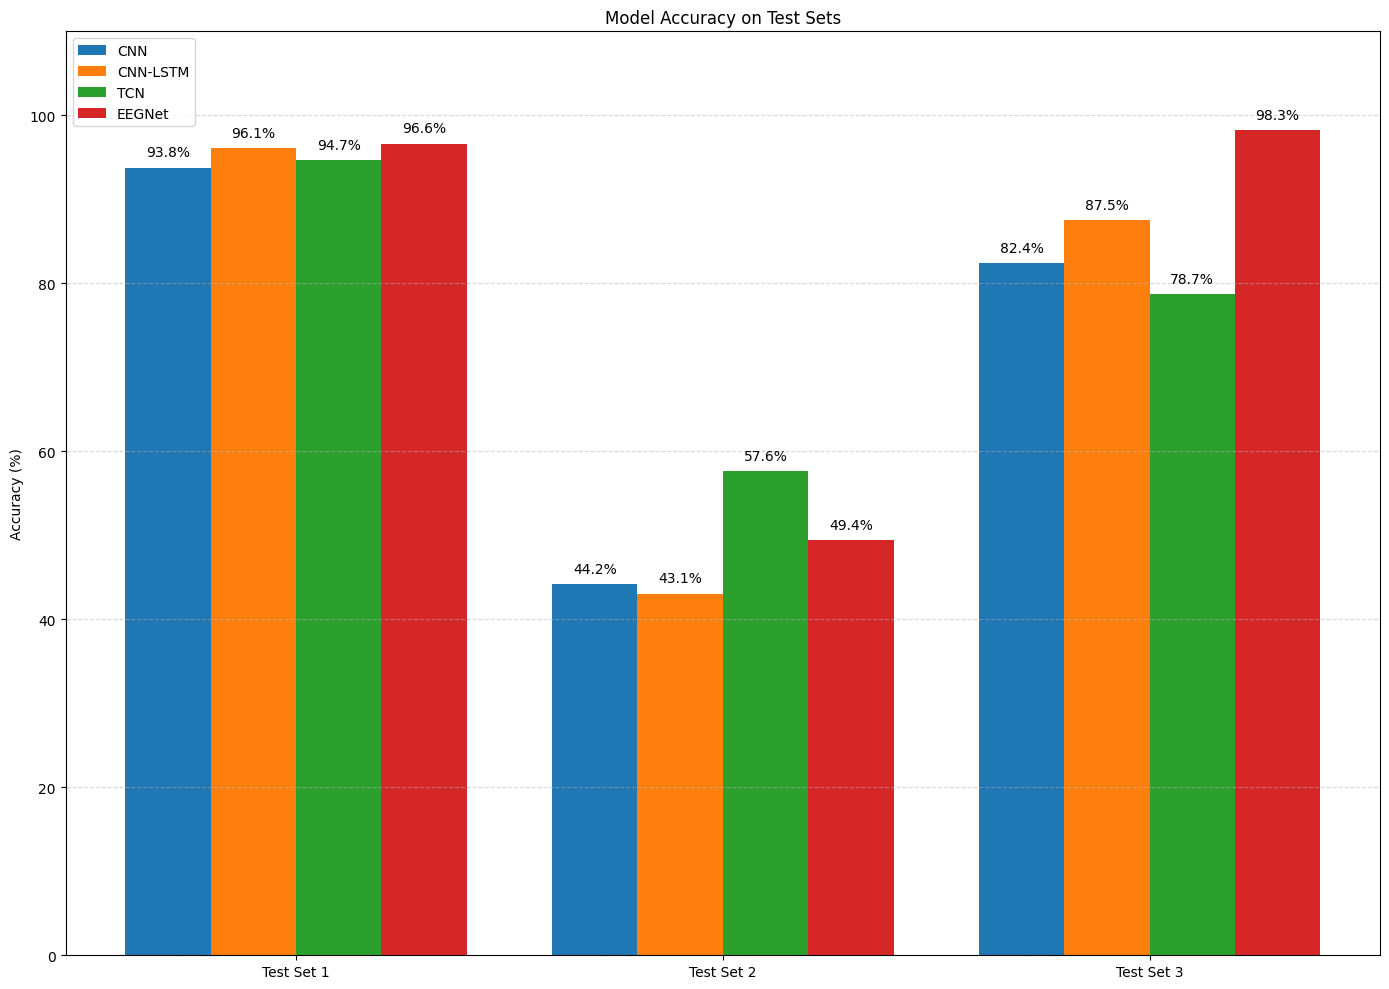

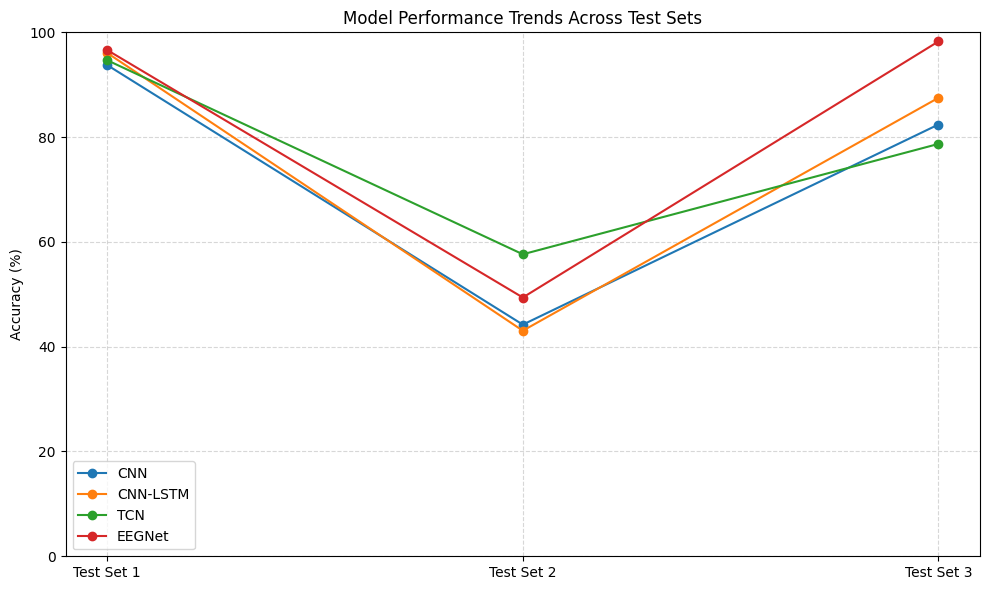

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# --- Evaluate all four best models on their test sets ---

# 1D test data already loaded as X_test1_1D, y_test1_1D_final, etc.
# 2D EEGNet test data:
X_test1_2D, y_test1_2D = preprocess_pipeline(TEST1_DIR, is_training=False, output_format='2d')
X_test2_2D, y_test2_2D = preprocess_pipeline(TEST2_DIR, is_training=False, output_format='2d')
X_test3_2D, y_test3_2D = preprocess_pipeline(TEST3_DIR, is_training=False, output_format='2d')

# CNN
_, acc1_simple_cnn = best_model_cnn.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
_, acc2_simple_cnn = best_model_cnn.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
_, acc3_simple_cnn = best_model_cnn.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)

# CNN-LSTM
_, acc1_hybrid = best_model_lstm.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
_, acc2_hybrid = best_model_lstm.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
_, acc3_hybrid = best_model_lstm.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)

# TCN
_, acc1_tcn = best_model_tcn.evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
_, acc2_tcn = best_model_tcn.evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
_, acc3_tcn = best_model_tcn.evaluate(X_test3_1D, y_test3_1D_final, verbose=0)

# EEGNet
_, acc1_eegnet = best_model_eeg.evaluate(X_test1_2D, y_test1_2D, verbose=0)
_, acc2_eegnet = best_model_eeg.evaluate(X_test2_2D, y_test2_2D, verbose=0)
_, acc3_eegnet = best_model_eeg.evaluate(X_test3_2D, y_test3_2D, verbose=0)

# Convert to percentages
cnn_accs    = [acc1_simple_cnn*100, acc2_simple_cnn*100, acc3_simple_cnn*100]
lstm_accs   = [acc1_hybrid*100,       acc2_hybrid*100,       acc3_hybrid*100]
tcn_accs    = [acc1_tcn*100,          acc2_tcn*100,          acc3_tcn*100]
eegnet_accs = [acc1_eegnet*100,       acc2_eegnet*100,       acc3_eegnet*100]

test_sets = ['Test Set 1', 'Test Set 2', 'Test Set 3']
x = np.arange(len(test_sets))
width = 0.2

# === Grouped Bar Plot ===
plt.figure(figsize=(14,10))
plt.bar(x - 1.5*width, cnn_accs,    width, label='CNN')
plt.bar(x - 0.5*width, lstm_accs,   width, label='CNN-LSTM')
plt.bar(x + 0.5*width, tcn_accs,    width, label='TCN')
plt.bar(x + 1.5*width, eegnet_accs, width, label='EEGNet')
for bar in plt.gca().patches:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # x = bar center
        h + 1,                            # y = just above bar
        f"{h:.1f}%",                      # label
        ha='center', va='bottom'
    )
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy on Test Sets')
plt.xticks(x, test_sets)
plt.ylim(0, 110)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === Line Plot for Model Trends ===
plt.figure(figsize=(10,6))
plt.plot(test_sets, cnn_accs,    marker='o', label='CNN')
plt.plot(test_sets, lstm_accs,   marker='o', label='CNN-LSTM')
plt.plot(test_sets, tcn_accs,    marker='o', label='TCN')
plt.plot(test_sets, eegnet_accs, marker='o', label='EEGNet')

plt.ylabel('Accuracy (%)')
plt.title('Model Performance Trends Across Test Sets')
plt.ylim(0, 100)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# --- Prepare test sets for 1D models (CNN, CNN-LSTM, TCN) ---
test_data_1d = {
    "Test Set 1": (X_test1_1D, y_test1_1D_final),
    "Test Set 2": (X_test2_1D, y_test2_1D_final),
    "Test Set 3": (X_test3_1D, y_test3_1D_final),
}

# --- Prepare test sets for EEGNet (2D) ---
X_test1_2D, y_test1_2D = preprocess_pipeline(TEST1_DIR, is_training=False, output_format='2d')
X_test2_2D, y_test2_2D = preprocess_pipeline(TEST2_DIR, is_training=False, output_format='2d')
X_test3_2D, y_test3_2D = preprocess_pipeline(TEST3_DIR, is_training=False, output_format='2d')
test_data_2d = {
    "Test Set 1": (X_test1_2D, y_test1_2D),
    "Test Set 2": (X_test2_2D, y_test2_2D),
    "Test Set 3": (X_test3_2D, y_test3_2D),
}

models = {
    "CNN":      best_models["CNN"],
    "CNN-LSTM": best_models["CNN-LSTM"],
    "TCN":      best_models["TCN"],
    "EEGNet":   best_models["EEGNet"],
}

for name, model in models.items():
    print(f"\n=== {name} ===\n")
    data_dict = test_data_2d if name == "EEGNet" else test_data_1d

    for ds_name, (X_test, y_test) in data_dict.items():
        # predict
        y_pred_probs = model.predict(X_test, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)

        # classification report
        print(f"--- {ds_name} ---")
        print(classification_report(
            y_test, y_pred,
            target_names=TASKS,
            digits=4
        ))

        # confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print("Confusion matrix:")
        print(cm)
        print()



=== CNN ===

--- Test Set 1 ---
                     precision    recall  f1-score   support

               rest     1.0000    1.0000    1.0000       108
         task_motor     0.8000    1.0000    0.8889       108
    task_story_math     1.0000    1.0000    1.0000       108
task_working_memory     1.0000    0.7500    0.8571       108

           accuracy                         0.9375       432
          macro avg     0.9500    0.9375    0.9365       432
       weighted avg     0.9500    0.9375    0.9365       432

Confusion matrix:
[[108   0   0   0]
 [  0 108   0   0]
 [  0   0 108   0]
 [  0  27   0  81]]

--- Test Set 2 ---
                     precision    recall  f1-score   support

               rest     1.0000    1.0000    1.0000       108
         task_motor     0.4346    0.7685    0.5552       108
    task_story_math     0.0000    0.0000    0.0000       108
task_working_memory     0.0000    0.0000    0.0000       108

           accuracy                         0.4421    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--- Test Set 3 ---
                     precision    recall  f1-score   support

               rest     1.0000    1.0000    1.0000       108
         task_motor     0.5879    0.9907    0.7379       108
    task_story_math     0.9706    0.3056    0.4648       108
task_working_memory     1.0000    1.0000    1.0000       108

           accuracy                         0.8241       432
          macro avg     0.8896    0.8241    0.8007       432
       weighted avg     0.8896    0.8241    0.8007       432

Confusion matrix:
[[108   0   0   0]
 [  0 107   1   0]
 [  0  75  33   0]
 [  0   0   0 108]]


=== CNN-LSTM ===

--- Test Set 1 ---
                     precision    recall  f1-score   support

               rest     1.0000    1.0000    1.0000       108
         task_motor     0.8640    1.0000    0.9270       108
    task_story_math     1.0000    1.0000    1.0000       108
task_working_memory     1.0000    0.8426    0.9146       108

           accuracy                         0.960

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


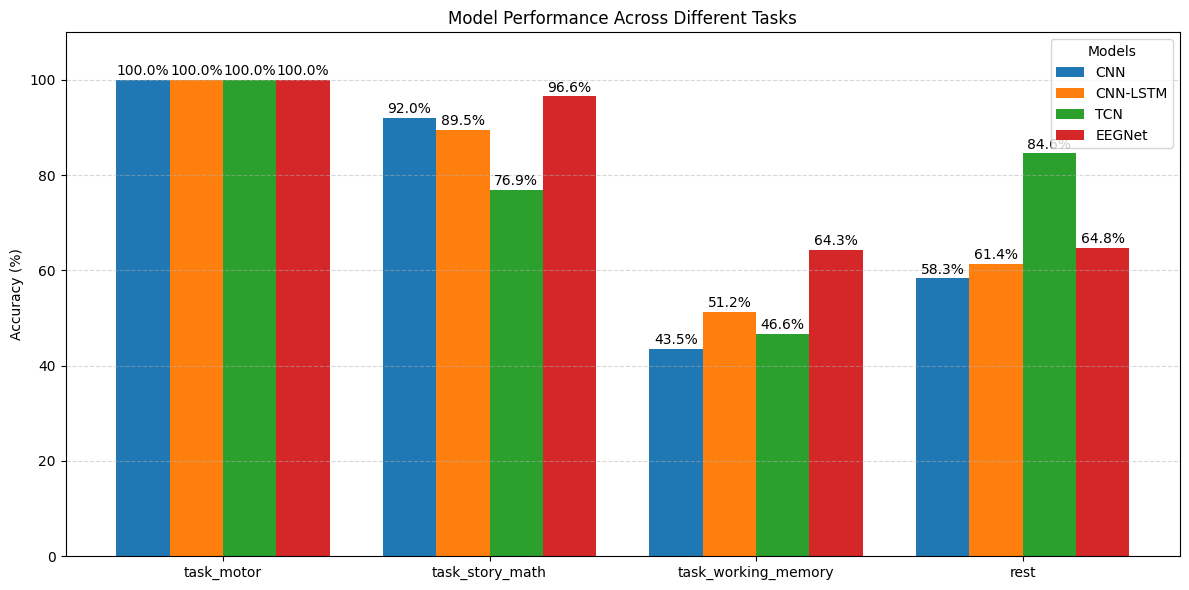

In [35]:
from sklearn.metrics import classification_report
import numpy as np

# 1) Stack all three 1D test sets
X_test_all_1D = np.concatenate([X_test1_1D, X_test2_1D, X_test3_1D], axis=0)
y_test_all_1D = np.concatenate([y_test1_1D_final, y_test2_1D_final, y_test3_1D_final], axis=0)

# 2) Stack all three 2D test sets
X_test_all_2D = np.concatenate([X_test1_2D, X_test2_2D, X_test3_2D], axis=0)
y_test_all_2D = np.concatenate([y_test1_2D,   y_test2_2D,   y_test3_2D],   axis=0)

# 3) Get per‐class recall from the classification report for each model
def per_class_recall(model, X, y):
    y_pred = np.argmax(model.predict(X), axis=1)
    rep = classification_report(y, y_pred, target_names=TASKS, output_dict=True)
    return [rep[t]['recall'] * 100 for t in TASKS]

cnn_accs    = per_class_recall(best_models["CNN"],      X_test_all_1D, y_test_all_1D)
lstm_accs   = per_class_recall(best_models["CNN-LSTM"], X_test_all_1D, y_test_all_1D)
tcn_accs    = per_class_recall(best_models["TCN"],      X_test_all_1D, y_test_all_1D)
eegnet_accs = per_class_recall(best_models["EEGNet"],   X_test_all_2D, y_test_all_2D)

# 4) Now draw exactly your same grouped‐bar code:
tasks = ['task_motor', 'task_story_math', 'task_working_memory', 'rest']
x = np.arange(len(tasks))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, cnn_accs,    width, label='CNN')
plt.bar(x - 0.5*width, lstm_accs,   width, label='CNN-LSTM')
plt.bar(x + 0.5*width, tcn_accs,    width, label='TCN')
plt.bar(x + 1.5*width, eegnet_accs, width, label='EEGNet')

# Annotate each bar
for i in range(len(tasks)):
    plt.text(x[i] - 1.5*width, cnn_accs[i]    + 1, f"{cnn_accs[i]:.1f}%", ha='center')
    plt.text(x[i] - 0.5*width, lstm_accs[i]   + 1, f"{lstm_accs[i]:.1f}%", ha='center')
    plt.text(x[i] + 0.5*width, tcn_accs[i]    + 1, f"{tcn_accs[i]:.1f}%", ha='center')
    plt.text(x[i] + 1.5*width, eegnet_accs[i] + 1, f"{eegnet_accs[i]:.1f}%", ha='center')

plt.ylabel('Accuracy (%)')
plt.title('Model Performance Across Different Tasks')
plt.xticks(x, tasks)
plt.ylim(0, 110)
plt.legend(title='Models')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [28]:
best_model_cnn.save('cnn_model.keras')  # Folder will be created if it doesn't exist
best_model_lstm.save('lstm_model.keras')  # Folder will be created if it doesn't exist
best_model_tcn.save('tcn_model.keras')  # Folder will be created if it doesn't exist
best_model_tcn.save('eeg_model.keras')

In [ ]:
# from tensorflow.keras.models import load_model
# cnn_load_model = load_model('/Users/youssefbenmansour/Desktop/Master/Period 4/DL/cnn_model.keras')
# lstm_load_model = load_model('/Users/youssefbenmansour/Desktop/Master/Period 4/DL/lstm_model.keras')
# tcn_load_model = load_model('/Users/youssefbenmansour/Desktop/Master/Period 4/DL/tcn_model.keras')
# eeg_load_model = load_model('/Users/youssefbenmansour/Desktop/Master/Period 4/DL/eegnet_cross.h5')

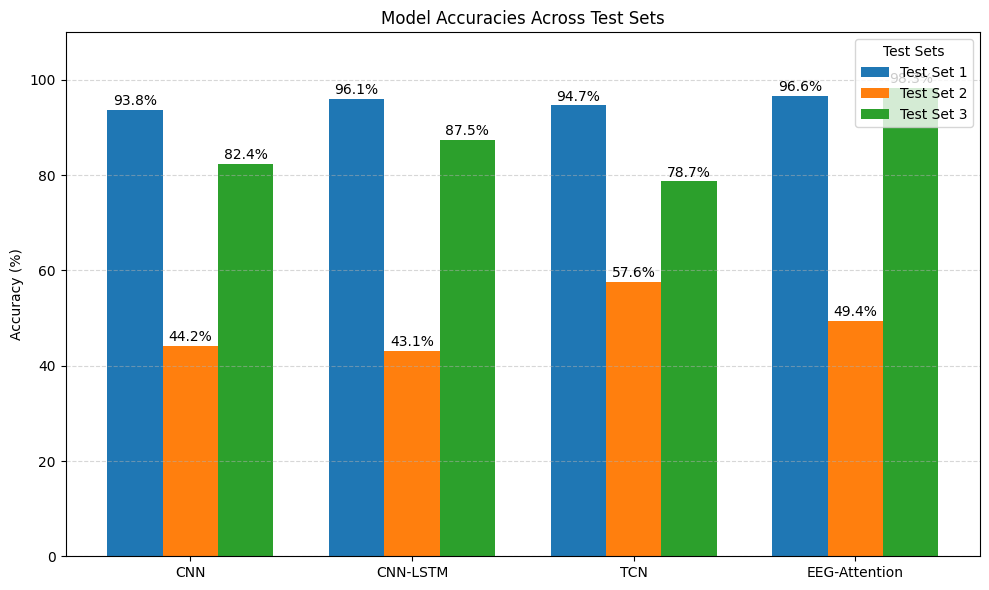

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# --- (Re-)evaluate each best model on the three test sets ---

# CNN (1D)
_, acc1_simple_cnn = best_models["CNN"].evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
_, acc2_simple_cnn = best_models["CNN"].evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
_, acc3_simple_cnn = best_models["CNN"].evaluate(X_test3_1D, y_test3_1D_final, verbose=0)

# CNN-LSTM (1D)
_, acc1_hybrid = best_models["CNN-LSTM"].evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
_, acc2_hybrid = best_models["CNN-LSTM"].evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
_, acc3_hybrid = best_models["CNN-LSTM"].evaluate(X_test3_1D, y_test3_1D_final, verbose=0)

# TCN (1D)
_, acc1_tcn = best_models["TCN"].evaluate(X_test1_1D, y_test1_1D_final, verbose=0)
_, acc2_tcn = best_models["TCN"].evaluate(X_test2_1D, y_test2_1D_final, verbose=0)
_, acc3_tcn = best_models["TCN"].evaluate(X_test3_1D, y_test3_1D_final, verbose=0)

# EEGNet (2D)
X_test1_2D, y_test1_2D = preprocess_pipeline(TEST1_DIR, is_training=False, output_format='2d')
X_test2_2D, y_test2_2D = preprocess_pipeline(TEST2_DIR, is_training=False, output_format='2d')
X_test3_2D, y_test3_2D = preprocess_pipeline(TEST3_DIR, is_training=False, output_format='2d')
_, acc1_eegnet = best_models["EEGNet"].evaluate(X_test1_2D, y_test1_2D, verbose=0)
_, acc2_eegnet = best_models["EEGNet"].evaluate(X_test2_2D, y_test2_2D, verbose=0)
_, acc3_eegnet = best_models["EEGNet"].evaluate(X_test3_2D, y_test3_2D, verbose=0)

# --- Assemble into lists (percentages) ---
test1_acc = [acc1_simple_cnn*100, acc1_hybrid*100, acc1_tcn*100, acc1_eegnet*100]
test2_acc = [acc2_simple_cnn*100, acc2_hybrid*100, acc2_tcn*100, acc2_eegnet*100]
test3_acc = [acc3_simple_cnn*100, acc3_hybrid*100, acc3_tcn*100, acc3_eegnet*100]

models = ['CNN', 'CNN-LSTM', 'TCN', 'EEG-Attention']
x = np.arange(len(models))
width = 0.25  # width of each bar

# === Grouped bar chart ===
plt.figure(figsize=(10,6))
plt.bar(x - width, test1_acc, width, label='Test Set 1')
plt.bar(x,         test2_acc, width, label='Test Set 2')
plt.bar(x + width, test3_acc, width, label='Test Set 3')

# annotate
for i in range(len(models)):
    plt.text(x[i] - width, test1_acc[i] + 1, f"{test1_acc[i]:.1f}%", ha='center')
    plt.text(x[i],         test2_acc[i] + 1, f"{test2_acc[i]:.1f}%", ha='center')
    plt.text(x[i] + width, test3_acc[i] + 1, f"{test3_acc[i]:.1f}%", ha='center')

plt.xticks(x, models)
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracies Across Test Sets')
plt.ylim(0, 110)
plt.legend(title='Test Sets')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [39]:
from sklearn.metrics import log_loss, matthews_corrcoef
import numpy as np
import tensorflow as tf  # for to_categorical

models = {
    "CNN":      best_models["CNN"],
    "CNN-LSTM": best_models["CNN-LSTM"],
    "TCN":      best_models["TCN"],
    "EEGNet":   best_models["EEGNet"],
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    data_dict = test_data_2d if name == "EEGNet" else test_data_1d

    for ds_name, (X_test, y_test) in data_dict.items():
        # predict
        y_pred_probs = model.predict(X_test, verbose=0)
        y_pred       = np.argmax(y_pred_probs, axis=1)

        # one-hot encode the true labels
        y_true_oh = tf.keras.utils.to_categorical(y_test, num_classes=len(TASKS))

        # classification report & confusion matrix (from before)
        print(f"\n-- {ds_name} --")
        print(classification_report(y_test, y_pred, target_names=TASKS, digits=4))
        print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

        # ----- new metrics -----
        # RMSE
        mse  = np.mean((y_pred_probs - y_true_oh)**2)
        rmse = np.sqrt(mse)
        print(f"RMSE (on probas): {rmse:.4f}")

        # log‐loss
        ll = log_loss(y_test, y_pred_probs)
        print(f"Log‐loss:       {ll:.4f}")

        # MCC (requires discrete preds)
        mcc = matthews_corrcoef(y_test, y_pred)
        print(f"Matthews CC:   {mcc:.4f}")
    print("\n" + "="*60)



=== CNN ===

-- Test Set 1 --
                     precision    recall  f1-score   support

               rest     1.0000    1.0000    1.0000       108
         task_motor     0.8000    1.0000    0.8889       108
    task_story_math     1.0000    1.0000    1.0000       108
task_working_memory     1.0000    0.7500    0.8571       108

           accuracy                         0.9375       432
          macro avg     0.9500    0.9375    0.9365       432
       weighted avg     0.9500    0.9375    0.9365       432

Confusion matrix:
 [[108   0   0   0]
 [  0 108   0   0]
 [  0   0 108   0]
 [  0  27   0  81]]
RMSE (on probas): 0.1657
Log‐loss:       0.5798
Matthews CC:   0.9215

-- Test Set 2 --
                     precision    recall  f1-score   support

               rest     1.0000    1.0000    1.0000       108
         task_motor     0.4346    0.7685    0.5552       108
    task_story_math     0.0000    0.0000    0.0000       108
task_working_memory     0.0000    0.0000    0.000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



-- Test Set 3 --
                     precision    recall  f1-score   support

               rest     1.0000    1.0000    1.0000       108
         task_motor     0.5879    0.9907    0.7379       108
    task_story_math     0.9706    0.3056    0.4648       108
task_working_memory     1.0000    1.0000    1.0000       108

           accuracy                         0.8241       432
          macro avg     0.8896    0.8241    0.8007       432
       weighted avg     0.8896    0.8241    0.8007       432

Confusion matrix:
 [[108   0   0   0]
 [  0 107   1   0]
 [  0  75  33   0]
 [  0   0   0 108]]
RMSE (on probas): 0.2929
Log‐loss:       1.9104
Matthews CC:   0.7973


=== CNN-LSTM ===

-- Test Set 1 --
                     precision    recall  f1-score   support

               rest     1.0000    1.0000    1.0000       108
         task_motor     0.8640    1.0000    0.9270       108
    task_story_math     1.0000    1.0000    1.0000       108
task_working_memory     1.0000    0.8426   

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# List of studies and corresponding titles
studies = [study_cnn, study_lstm, study_tcn]
titles = ['CNN Study', 'LSTM Study', 'TCM Study']

for study, title in zip(studies, titles):
    window_sizes = []
    step_sizes = []
    accuracies = []

    for trial in study.trials:
        if trial.value is not None and "window_size" in trial.params and "step_size" in trial.params:
            window_sizes.append(trial.params["window_size"])
            step_sizes.append(trial.params["step_size"])
            accuracies.append(trial.value)

    if not accuracies:
        print(f"No valid trials for {title}. Skipping plot.")
        continue

    window_sizes = np.array(window_sizes)
    step_sizes = np.array(step_sizes)
    accuracies = np.array(accuracies)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(window_sizes, step_sizes, c=accuracies, cmap='viridis', s=100, edgecolors='k')
    plt.colorbar(scatter, label='Accuracy')
    plt.xlabel('Window Size')
    plt.ylabel('Step Size')
    plt.title(f'Accuracy per Window Size and Step Size ({title})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


NameError: name 'study_cnn' is not defined